In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from datetime import datetime
import heapq
import math
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

In [3]:
def collaborative_filtering_user(R, id, K):
    row = R.loc[id]
    kNN = NearestNeighbors(n_neighbors = K + 1, algorithm="brute", metric='cosine')
    kNN.fit(R)
    distances, indices = kNN.kneighbors(row.values.reshape(1, -1), return_distance=True)
    similarities = 1 / (distances[0][1:] + 1e-8)
    similarities = similarities / np.sum(similarities)
    user_ratings = row.to_numpy() 
    predicted_ratings = np.zeros_like(user_ratings, dtype='float64')
    for idx, neighbor_idx in enumerate(indices[0][1:]):
        neighbor_ratings = R.iloc[neighbor_idx].to_numpy() 
        predicted_ratings += similarities[idx] * neighbor_ratings
    already_rated = R.loc[id] > 0
    predicted_ratings[already_rated] = 0
    top_movies_indices = heapq.nlargest(K, range(len(predicted_ratings)), key=lambda i: predicted_ratings[i])
    return R.columns[[idx for idx in top_movies_indices]]

In [4]:
def collaborative_filtering_item(R, id, K):
    item_matrix = cosine_similarity(R.T)
    #item_matrix =  1 - pairwise_distances(R.values.T, metric='jaccard')
    #item_matrix = np.dot(R.T, R)
    predicted_ratings = np.dot(item_matrix, R.loc[id].values) / (np.sum(item_matrix, axis=1)+ 1e-8)
    already_rated = R.loc[id] > 0
    predicted_ratings[already_rated] = 0
    top_movies_indices = heapq.nlargest(K, range(len(predicted_ratings)), key=lambda i: predicted_ratings[i])
    return R.columns[[idx for idx in top_movies_indices]]

In [5]:
#LOAD DATASETS

movies = pd.read_csv('../data/ml-latest-small/movies.csv')
ratings = pd.read_csv('../data/ml-latest-small/ratings.csv')
ratings_sorted = ratings.sort_values("timestamp")

split_year = 2018
training_data = ratings_sorted[pd.to_datetime(ratings_sorted['timestamp'], unit='s')<datetime(split_year, 1, 1, 0, 0, 0)]
simulation_data = ratings_sorted[(pd.to_datetime(ratings_sorted['timestamp'], unit='s')>=datetime(split_year, 1, 1, 0, 0, 0)) ]
simulation_users = pd.DataFrame({'userId': list(set(simulation_data['userId'])-set(training_data['userId'])), 
                                 'follow':0,
                                 'total':0})
simulation_users = simulation_users.set_index('userId')
movieList = sorted(movies['movieId'].unique())
userList = sorted(ratings['userId'].unique())

full_matrix = pd.DataFrame(0.0 , index=userList, columns=movieList)
pivot_matrix = training_data.pivot(index='userId', columns='movieId', values='rating')
full_matrix.update(pivot_matrix, overwrite=True)

tag_genome = pd.read_csv('../data/ml-latest-small/genome-scores.csv')
tag_genome = tag_genome.set_index("movieId")
tag_genome = tag_genome['relevance']
tag_genome.head()

movie_name = pd.read_csv("../data/ml-latest-small/movies.csv")
movie_name = movie_name.set_index("movieId")
movie_name = movie_name["title"]
movie_name.head()

print(ratings_sorted.shape)
print(training_data.shape)
print(simulation_data.shape)
print(simulation_users.shape)
print(tag_genome.shape)



(100836, 4)
(94418, 4)
(6418, 4)
(29, 2)
(18472128,)


In [6]:
def computeRecommendation(id,method,k):
    if method.lower()=="item":
        recommendation = collaborative_filtering_item(full_matrix, id,k)
    else:
        recommendation = collaborative_filtering_user(full_matrix, id,k)
    return recommendation

In [7]:
#SIMULATION

k = 15
method = "user" # user or item

simulation_users['choosen'] = simulation_users.apply(lambda x: [], axis=1)

siz = simulation_data.shape[0]
print(f"0%\t",end="\r")
i = 0
for _ , row in simulation_data.iterrows():
    i += 1
    user_id = int(row['userId'])
    movie_id = row['movieId']
    rating = row['rating']
    print(f"{round(i/siz*100,2)}%\t",end="\r")
    if user_id in simulation_users.index:
        recommendation = computeRecommendation(user_id,method,k)
        if movie_id in recommendation:
            simulation_users.loc[user_id, 'follow'] += 1
        simulation_users.loc[user_id, 'total'] += 1
        simulation_users.loc[user_id,'choosen'].append(movie_id)
    full_matrix.loc[user_id,movie_id] = rating

simulation_users.head(50)


,follow,total,choosen
userId,,,
514,28,397,"[1704.0, 356.0, 4993.0, 7153.0, 5952.0, 58559...."
258,4,25,"[318.0, 2571.0, 47099.0, 1197.0, 122918.0, 122..."
519,2,26,"[318.0, 1704.0, 51935.0, 2329.0, 5989.0, 1968...."
272,1,31,"[318.0, 2571.0, 68358.0, 4993.0, 122922.0, 158..."
153,11,179,"[356.0, 1704.0, 2324.0, 4308.0, 6373.0, 1196.0..."
25,14,26,"[7153.0, 5952.0, 4993.0, 2571.0, 79132.0, 260...."
417,15,67,"[2959.0, 2571.0, 858.0, 2712.0, 4995.0, 4896.0..."
296,8,27,"[318.0, 527.0, 79132.0, 2959.0, 1704.0, 2571.0..."
556,8,32,"[4993.0, 7153.0, 5952.0, 48394.0, 4896.0, 7609..."


In [ ]:
# SAVE SIMULATION
simulation_users.to_csv("data/experiment2/simulation.csv")

In [ ]:
# LOAD SIMULATION
#simulation_users = pd.read_csv('data/experiment2/simulation.csv')
#simulation_users.set_index("userId")

In [10]:
max_dist = 44.24
min_dist = 5.1

def tagGenomeDistance(recommendation):
    if len(recommendation) < 2:
        return 0 

    distances = []
    rec_movies = [rec for rec in recommendation if rec in tag_genome.index]
    filtered_tags = tag_genome.loc[rec_movies]

    # Compute pairwise distances for unique movie pairs
    for _, m1 in enumerate(rec_movies):
        for _, m2 in enumerate(rec_movies):
            vec1 = filtered_tags.loc[m1].values
            vec2 = filtered_tags.loc[m2].values
            sommatory = 0  
            for j in range(len(vec1)):
                a = 1+vec1[j]*4
                b = 1+vec2[j]*4
                sommatory += math.pow(a-b,2)
            dist = math.sqrt(sommatory)
            distances.append(dist)

    # Return the average homogenity
    avg_dist = sum(distances) / len(distances) if distances else 0
    norm_dist = math.log((avg_dist-min_dist)/(max_dist-min_dist)+1)*100
    return norm_dist

In [11]:
def computeTopKFilm(ds,K):
    #print(ds)
    my_dict = {}
    for film_list in ds:
        for film in film_list:
            if not film in my_dict:
                my_dict[film]=0
            my_dict[film]+=1   
    sorted_dict = dict(sorted(my_dict.items(), key=lambda item: item[1]))
    topK = list(sorted_dict.keys())[-K:]
    return topK

In [12]:
def computePairHomogenity(list1,list2):
    return len(set(list1) & set(list2))/len(list1)*100

In [13]:
def computeHomogenity(recommended,topk):
    if len(recommendation) < 2:
        return 0 
    return computePairHomogenity(recommended,topk)
    

In [14]:
def computeFilmNames(recommendation):
    r = [rec for rec in recommendation if rec in movie_name.index]
    return movie_name[r].values

In [15]:
# create first visualization
picture1 = simulation_users.copy().reset_index()
picture1['recommendation']=picture1['userId'].apply(lambda x: computeRecommendation(x, method, k))
picture1['last recommendation'] = picture1['recommendation'].apply(computeFilmNames)
picture1['choosen'] = picture1['choosen'].apply(lambda x: [int(item) for item in x[-23:]])
picture1['watch history'] = picture1['choosen'].apply(computeFilmNames)
picture1[["userId","follow","total","last recommendation","watch history"]].tail(10)

,userId,follow,total,last recommendation,watch history
19,209,11,35,"[Dark Knight, The (2008), Schindler's List (19...","[Matrix, The (1999), 127 Hours (2010), Watchme..."
20,338,7,39,"[Inception (2010), Matrix, The (1999), America...","[Schindler's List (1993), Fight Club (1999), B..."
21,596,31,411,"[Shawshank Redemption, The (1994), Seven (a.k....","[Pitch Black (2000), Godzilla (1998), Romy and..."
22,89,5,518,"[Up (2009), Dark Knight, The (2008), Pirates o...","[Dead Hate the Living!, The (2000), RoboGeisha..."
23,98,5,92,"[Fight Club (1999), Raiders of the Lost Ark (I...","[Star Wars: The Last Jedi (2017), Get Out (201..."
24,362,21,109,"[Dark Knight, The (2008), Saving Private Ryan ...","[Dangerous Minds (1995), Thing, The (1982), In..."
25,491,6,64,[Harry Potter and the Prisoner of Azkaban (200...,"[Ted (2012), Marley & Me (2008), Santa Clause,..."
26,111,23,646,[Star Wars: Episode V - The Empire Strikes Bac...,"[O.J.: Made in America (2016), Honest Liar, An..."
27,248,10,51,"[Lord of the Rings: The Two Towers, The (2002)...",[Pirates of the Caribbean: On Stranger Tides (...
28,382,19,291,[Pirates of the Caribbean: The Curse of the Bl...,"[Zoolander 2 (2016), Sucker Punch (2011), Anna..."


In [16]:
# USER EFFECT: effect of following recommendations on future recommendations
result = simulation_users.copy()
result['userId']=result.index
result['recommendation']=result['userId'].apply(lambda x: computeRecommendation(x, method, k))
result['last_recommendation'] = result['recommendation'].apply(computeFilmNames)
result['diversity'] = result['recommendation'].apply(tagGenomeDistance)
topK = computeTopKFilm(result['recommendation'],k)
result['homogeneity'] = result['recommendation'].apply(lambda x: computeHomogenity(x, topK))
result['follower']=result["follow"]/result["total"]*100
result[["follower","homogeneity","diversity","last_recommendation","choosen"]].head(50)

,follower,homogeneity,diversity,last_recommendation,choosen
userId,,,,,
514,7.052897,6.666667,45.540104,"[Braveheart (1995), Shawshank Redemption, The ...","[1704.0, 356.0, 4993.0, 7153.0, 5952.0, 58559...."
258,16.000000,46.666667,44.094128,"[Inception (2010), Forrest Gump (1994), Lord o...","[318.0, 2571.0, 47099.0, 1197.0, 122918.0, 122..."
519,7.692308,46.666667,46.173685,"[Fight Club (1999), Matrix, The (1999), Pulp F...","[318.0, 1704.0, 51935.0, 2329.0, 5989.0, 1968...."
272,3.225806,53.333333,43.432954,"[Inception (2010), Fight Club (1999), Raiders ...","[318.0, 2571.0, 68358.0, 4993.0, 122922.0, 158..."
153,6.145251,33.333333,44.420173,"[Shawshank Redemption, The (1994), Silence of ...","[356.0, 1704.0, 2324.0, 4308.0, 6373.0, 1196.0..."
25,53.846154,26.666667,46.358331,"[Fight Club (1999), Shawshank Redemption, The ...","[7153.0, 5952.0, 4993.0, 2571.0, 79132.0, 260...."
417,22.388060,20.000000,44.993588,"[Star Wars: Episode IV - A New Hope (1977), Fa...","[2959.0, 2571.0, 858.0, 2712.0, 4995.0, 4896.0..."
296,29.629630,40.000000,44.680173,"[Silence of the Lambs, The (1991), Lord of the...","[318.0, 527.0, 79132.0, 2959.0, 1704.0, 2571.0..."
556,25.000000,60.000000,45.105501,[Harry Potter and the Deathly Hallows: Part 1 ...,"[4993.0, 7153.0, 5952.0, 48394.0, 4896.0, 7609..."


In [ ]:
# SAVE SIMULATION
result.to_csv("data/experiment2/result1.csv")

C:\Users\marco\AppData\Local\Temp\ipykernel_194544\3874422020.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=picture2, x='index', y='homogeneity', palette=colors)


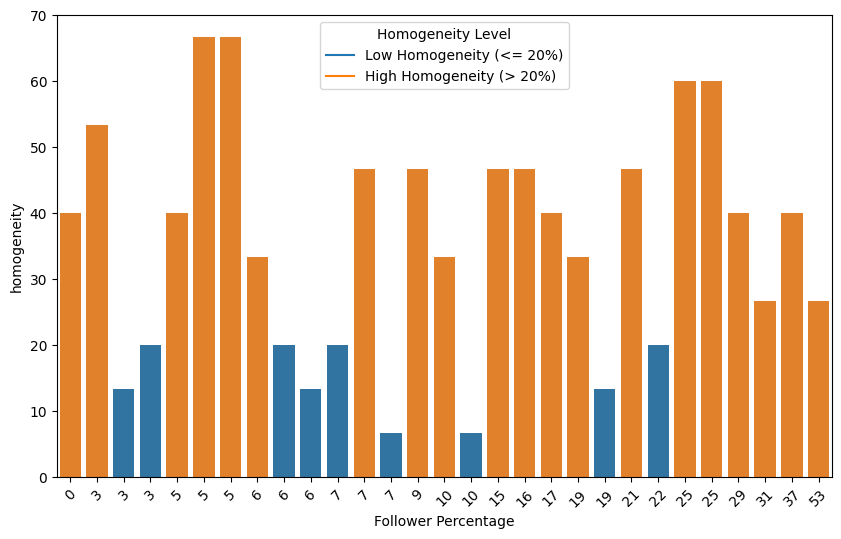

In [17]:
# create second visualization
picture2 = result.copy()
picture2['follower'] = (picture2['follower']).astype(int)
picture2 = picture2[["follower", "homogeneity", "diversity"]].reset_index()
picture2 = picture2[["follower", "homogeneity", "diversity"]].sort_values("follower").reset_index()
picture2 = picture2[["follower","homogeneity","diversity"]].reset_index()
colors = ['#1f77b4' if value <= 20 else '#ff7f0e' for value in picture2['homogeneity']]  # Blue for low, Orange for high
plt.figure(figsize=(10, 6))
sns.barplot(data=picture2, x='index', y='homogeneity', palette=colors)
plt.xticks(ticks=range(len(picture2)), labels=picture2['follower'], rotation=45)
plt.xlabel("Follower Percentage")
low_homogeneity = mlines.Line2D([], [], color='#1f77b4', label='Low Homogeneity (<= 20%)')
high_homogeneity = mlines.Line2D([], [], color='#ff7f0e', label='High Homogeneity (> 20%)')
plt.legend(handles=[low_homogeneity, high_homogeneity], title='Homogeneity Level')
plt.show()

In [18]:
#ATE on recommendation DIVERSITY of following

Ft = 20
Dt = 46

all = len(result['follower'])
pF = len(result[result['follower']>=Ft])/all
pD = len(result[result['diversity']>=Dt])/all
pDF = len(result[(result['follower']>=Ft) & ((result['diversity']>=Dt))])/all
pDnF = len(result[(result['follower']<Ft) & ((result['diversity']>=Dt))])/all
pnDnF = len(result[(result['follower']<Ft) & ((result['diversity']<Dt))])/all
pnDF = len(result[(result['follower']>=Ft) & ((result['diversity']<Dt))])/all
pnF = 1 - pF

print(f'pF {round(pF,3)}')
print(f'pD {round(pD,3)}')
print(f'pDF {round(pDF,3)}')
print(f'pDnF {round(pDnF,3)}')

ATE = pDF/pF - pDnF/pnF  
print(f'\nATE {round(ATE,3)}')

pF 0.276
pD 0.276
pDF 0.103
pDnF 0.172

ATE 0.137


In [19]:
#ATE on recommendation HOMOGENEITY of following

Ft = 20
Ht = 20
 
all = len(result['follower'])
pF = len(result[result['follower']>=Ft])/all
pH = len(result[result['homogeneity']>=Ht])/all
pHF = len(result[(result['follower']>=Ft) & (result['homogeneity']>=Ht)])/all
pHnF = len(result[(result['follower']<Ft) & (result['homogeneity']>=Ht)])/all
pnHnF = len(result[(result['follower']<Ft) & (result['homogeneity']<Ht)])/all
pnHF = len(result[(result['follower']>=Ft) & (result['homogeneity']<Ht)])/all
pnF = 1 -pF

print(f'pF {round(pF,3)}')
print(f'pH {round(pH,3)}')
print(f'pHF {round(pHF,3)}')
print(f'pHnF {round(pHnF,3)}')

ATE = pHF/pF - pHnF/pnF 
print(f'\nATE {round(ATE,3)}')


pF 0.276
pH 0.828
pHF 0.276
pHnF 0.552

ATE 0.238


In [20]:
#EXPERIMENT with CLUSTERING: no significant result -> use homogeneity score instead
thr = 0.1

cluster_users = result.copy()
cluster_users = cluster_users.sort_index()
cluster_users["cluster"]=-1
cluster_users["hom"]=thr

for i, row1 in cluster_users.iterrows():
    topk = []
    maxhom = row1["hom"]
    cluster = -1
    for j, row2 in cluster_users.iterrows():
        if j>i:
            hom = computePairHomogenity(row1["recommendation"],row2["recommendation"])
            if hom > maxhom and hom > row2["hom"]:
                cluster = i
                maxhom = hom
                topk = list(set(row1["recommendation"]) & set(row2["recommendation"]))
    if cluster>=0:
        for j, row2 in cluster_users.iterrows():
            if j>i:
                hom = computeHomogenity(row2["recommendation"],topk)
                if hom >= row2["hom"]:
                    cluster_users.loc[j,"cluster"]=cluster
                    cluster_users.loc[j,"hom"]=hom
        cluster_users.loc[i,"cluster"]=cluster
        cluster_users.loc[i,"hom"]=maxhom
    elif cluster_users.loc[i,"cluster"]==-1:
        cluster_users.loc[i,"cluster"]=i

cluster_users['cluster_count'] = cluster_users.groupby('cluster')['cluster'].transform('count')
cc = cluster_users[["last_recommendation","cluster","cluster_count","follower","choosen"]].sort_values(by='cluster', ascending=True, inplace=False)
cc.head(50)

,last_recommendation,cluster,cluster_count,follower,choosen
userId,,,,,
25,"[Fight Club (1999), Shawshank Redemption, The ...",25,2,53.846154,"[7153.0, 5952.0, 4993.0, 2571.0, 79132.0, 260...."
514,"[Braveheart (1995), Shawshank Redemption, The ...",25,2,7.052897,"[1704.0, 356.0, 4993.0, 7153.0, 5952.0, 58559...."
62,"[Terminator 2: Judgment Day (1991), Finding Ne...",62,1,10.109290,"[318.0, 858.0, 527.0, 593.0, 2959.0, 1221.0, 2..."
77,"[Fight Club (1999), Indiana Jones and the Last...",77,2,37.931034,"[260.0, 1196.0, 1198.0, 2571.0, 1210.0, 7153.0..."
567,"[Matrix, The (1999), Dark Knight Rises, The (2...",77,2,3.636364,"[50.0, 4226.0, 56782.0, 122912.0, 177765.0, 18..."
89,"[Up (2009), Dark Knight, The (2008), Pirates o...",89,1,0.965251,"[750.0, 2324.0, 92259.0, 1136.0, 1197.0, 4973...."
98,"[Fight Club (1999), Raiders of the Lost Ark (I...",98,2,5.434783,"[79132.0, 109487.0, 164179.0, 1704.0, 2324.0, ..."
459,"[WALL·E (2008), Lord of the Rings: The Fellows...",98,2,15.384615,"[79132.0, 2571.0, 97913.0, 95510.0, 177765.0, ..."
111,[Star Wars: Episode V - The Empire Strikes Bac...,111,1,3.560372,"[68954.0, 1036.0, 2571.0, 122918.0, 54286.0, 3..."


In [21]:
# ATE using clustering size as metric

ft = 20
S = 2
all = len(cluster_users['follower'])
pF = len(cluster_users[cluster_users['follower']>=ft])/all
pH = len(cluster_users['cluster_count']>=S)/all
pHF = len(cluster_users[(cluster_users['follower']>=ft) & (cluster_users['cluster_count']>=S)])/all
pHnF = len(cluster_users[(cluster_users['follower']<ft) & (cluster_users['cluster_count']>=S)])/all
pnHnF = len(cluster_users[(cluster_users['follower']<ft) & (cluster_users['cluster_count']<S)])/all
pnHF = len(cluster_users[(cluster_users['follower']>=ft) & (cluster_users['cluster_count']<S)])/all
pnF = 1 - pF

print(f'pF {round(pF,3)}')
print(f'pH {round(pH,3)}')
print(f'pHF {round(pHF,3)}')
print(f'pHnF {round(pHnF,3)}')

ATE = pHF/pF - pHnF/pnF
print(f'\nATE {round(ATE,3)}')

pF 0.276
pH 1.0
pHF 0.138
pHnF 0.448

ATE -0.119


In [22]:
# ALGORITHM EFFECT: effect of following recommendations on watch history
result1 = simulation_users.copy()
result1['userId']=result1.index
result1['choosen'] = result1['choosen'].apply(lambda x: [int(item) for item in x[-23:]])
result1['diversity'] = result1['choosen'].apply(tagGenomeDistance)
result1['follower']=result1["follow"]/result1["total"]*100
topK = computeTopKFilm(result1['choosen'],k)
result1['homogeneity'] = result1['choosen'].apply(lambda x: computeHomogenity(x, topK))
result1[["follower","diversity","homogeneity","choosen"]].head(50)

,follower,diversity,homogeneity,choosen
userId,,,,
514,7.052897,41.270242,8.695652,"[3196, 167018, 26375, 135216, 180263, 182727, ..."
258,16.000000,47.385348,8.695652,"[47099, 1197, 122918, 122916, 527, 68954, 1229..."
519,7.692308,39.981059,4.347826,"[2329, 5989, 1968, 356, 3408, 134393, 88163, 4..."
272,3.225806,46.346200,4.347826,"[44191, 34405, 51662, 6365, 99114, 1721, 17776..."
153,6.145251,41.654512,8.695652,"[7317, 6793, 69644, 33679, 8528, 2355, 788, 13..."
25,53.846154,45.663632,21.739130,"[2571, 79132, 260, 527, 231, 122912, 176371, 1..."
417,22.388060,47.094110,4.347826,"[8914, 288, 58559, 81845, 296, 2329, 92259, 12..."
296,29.629630,47.924890,4.347826,"[1704, 2571, 2324, 2028, 296, 110, 50, 356, 31..."
556,25.000000,35.065142,17.391304,"[5816, 88125, 8368, 6539, 40815, 74789, 54001,..."


In [ ]:
# SAVE SIMULATION
result1.to_csv("data/experiment2/result2.csv")

In [25]:
#ATE on watch history DIVERSITY of following

Ft = 20
Dt = 46

all = len(result1['follower'])
pF = len(result1[result['follower']>=Ft])/all
pD = len(result1[result['diversity']>=Dt])/all
pDF = len(result1[(result['follower']>=Ft) & ((result1['diversity']>=Dt))])/all
pDnF = len(result1[(result['follower']<Ft) & ((result1['diversity']>=Dt))])/all
pnDnF = len(result1[(result['follower']<Ft) & ((result1['diversity']<Dt))])/all
pnDF = len(result1[(result['follower']>=Ft) & ((result1['diversity']<Dt))])/all
pnF = 1 - pF

print(f'pF {round(pF,3)}')
print(f'pD {round(pD,3)}')
print(f'pDF {round(pDF,3)}')
print(f'pDnF {round(pDnF,3)}')

ATE = pDF/pF - pDnF/pnF  
print(f'\nATE {round(ATE,3)}')

pF 0.276
pD 0.276
pDF 0.138
pDnF 0.103

ATE 0.357


In [26]:
#ATE on watch history HOMOGENEITY of following

Ft = 20
Ht = 20
 
all = len(result1['follower'])
pF = len(result1[result['follower']>=Ft])/all
pH = len(result1[result['homogeneity']>=Ht])/all
pHF = len(result1[(result['follower']>=Ft) & (result1['homogeneity']>=Ht)])/all
pHnF = len(result1[(result['follower']<Ft) & (result1['homogeneity']>=Ht)])/all
pnHnF = len(result1[(result['follower']<Ft) & (result1['homogeneity']<Ht)])/all
pnHF = len(result1[(result['follower']>=Ft) & (result1['homogeneity']<Ht)])/all
pnF = 1 -pF

print(f'pF {round(pF,3)}')
print(f'pH {round(pH,3)}')
print(f'pHF {round(pHF,3)}')
print(f'pHnF {round(pHnF,3)}')

ATE = pHF/pF - pHnF/pnF 
print(f'\nATE {round(ATE,3)}')

pF 0.276
pH 0.828
pHF 0.069
pHnF 0.034

ATE 0.202
